## Data setup:

In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random

In [3]:
import os
import random
from PIL import Image
from torch.utils.data import Dataset

In [97]:
class MoleDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Get all target_1 images
        target_1_path = os.path.join(image_dir, "target_1")
        target_1_images = [img_name for img_name in os.listdir(target_1_path) if os.path.isfile(os.path.join(target_1_path, img_name))]
        
        # Get all target_0 images
        target_0_path = os.path.join(image_dir, "target_0")
        target_0_images = [img_name for img_name in os.listdir(target_0_path) if os.path.isfile(os.path.join(target_0_path, img_name))]
        
        # Subsample target_0 images to 1/100 of their original size
        subsample_size = max(1, len(target_0_images) // 100)  # Ensure at least 1 image is sampled
        target_0_images_subsampled = random.sample(target_0_images, subsample_size)
        
        # Add all target_1 images
        for img_name in target_1_images:
            self.images.append(os.path.join(target_1_path, img_name))
            self.labels.append(1)
        
        # Add the subsampled target_0 images
        for img_name in target_0_images_subsampled:
            self.images.append(os.path.join(target_0_path, img_name))
            self.labels.append(0)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")  # Open image and convert to RGB
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

## Data Loaders

In [65]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch

In [66]:
class CrossValidationDataModule(pl.LightningDataModule):
    def __init__(self, image_dir, batch_size=32, n_splits=5, fold_idx=0):
        super().__init__()
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.n_splits = n_splits
        self.fold_idx = fold_idx
        
        # Keep the same transforms as before
        self.train_transform = transforms.Compose([
            transforms.Resize((224, 224)),transforms.Resize((224, 224)),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
            transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05), fill=0),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
            transforms.RandomRotation(degrees=180, fill=0),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.2, scale=(0.02, 0.06), ratio=(0.3, 3.3), value=0)
        ])

        self.val_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            # transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def setup(self, stage=None):
        # Initialize dataset without transforms
        full_dataset = MoleDataset(self.image_dir, transform=None)
        
        # Get all labels for stratification
        labels = np.array(full_dataset.labels)
        
        # Initialize the KFold cross validator
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        
        # Get the train and validation indices for the current fold
        splits = list(skf.split(np.zeros(len(labels)), labels))
        train_idx, val_idx = splits[self.fold_idx]
        
        # Create train and validation datasets with appropriate transforms
        train_dataset = MoleDataset(self.image_dir, transform=self.train_transform)
        val_dataset = MoleDataset(self.image_dir, transform=self.val_transform)
        
        # Create subsets using the fold indices
        self.train_dataset = torch.utils.data.Subset(train_dataset, train_idx)
        self.val_dataset = torch.utils.data.Subset(val_dataset, val_idx)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)



In [111]:
class MoleDataModule(pl.LightningDataModule):
    def __init__(self, image_dir, batch_size=32, val_split=0.001, use_all_data=False):
        super().__init__()
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.val_split = val_split
        self.use_all_data = use_all_data

        # Define separate transforms for training and validation
        self.train_transform = transforms.Compose([
             transforms.Resize((224, 224)),
            # transforms.CenterCrop((224, 224)),
            transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
            transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05), fill=0),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
            transforms.RandomRotation(degrees=180, fill=0),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.2, scale=(0.02, 0.06), ratio=(0.3, 3.3), value=0)
        ])

        self.val_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            # transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def setup(self, stage=None):
        # Initialize full dataset
        full_dataset = MoleDataset(self.image_dir, transform=None)
        
        if self.use_all_data:
            # Use entire dataset for training
            self.train_dataset = MoleDataset(self.image_dir, transform=self.train_transform)
            self.val_dataset = None  # No validation set
        else:
            # Existing train-val split logic
            labels = full_dataset.labels
            train_indices, val_indices = train_test_split(
                range(len(full_dataset)),
                test_size=self.val_split,
                stratify=labels,
                random_state=42
            )

            # Apply different transforms for training and validation datasets
            train_dataset = MoleDataset(self.image_dir, transform=self.train_transform)
            val_dataset = MoleDataset(self.image_dir, transform=self.val_transform)

            self.train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
            self.val_dataset = torch.utils.data.Subset(val_dataset, val_indices)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        # Return None if no validation set
        if self.val_dataset is None:
            return None
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)
    


In [68]:
# Usage
batch_size = 32
image_dir = "isic-2024-challenge/train_folder"  
mole_data_module = MoleDataModule(image_dir, batch_size)
mole_data_module.setup()

# Check train and validation data loaders
train_loader = mole_data_module.train_dataloader()
val_loader = mole_data_module.val_dataloader()

# Verify by printing the first batch
for images, labels in train_loader:
    print(images.shape, labels.shape)  # Should print (batch_size, 3, 224, 224) and (batch_size,)
    break


torch.Size([32, 3, 224, 224]) torch.Size([32])


## Lightning module

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torch
from torch import nn
from torchmetrics.classification import BinaryAccuracy
from torchvision.utils import make_grid
from sklearn.metrics import roc_curve
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import io
from torchmetrics import Accuracy


## CNNLSTM

In [70]:
# class MoleCNN(nn.Module):
#     def __init__(self, num_classes=1):  # For binary classification, num_classes is 1
#         super(MoleCNN, self).__init__()
        
#         # First convolutional layer
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)  
#         # Input: (3, 224, 224) -> Output: (16, 224, 224)
        
#         # Second convolutional layer
#         self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)  
#         # Input: (16, 224, 224) -> Output: (32, 224, 224)
        
#         # Max pooling layer
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  
#         # Output after pooling: (16, 112, 112) -> (32, 112, 112) after second conv
        
#         # Fully connected layer
#         self.fc1 = nn.Linear(32 * 56 * 56, 128)  # Correct dimensions: 100352 -> 128  # Flattened output from pooling
#         self.fc2 = nn.Linear(128, num_classes)  # Single output for binary classification
    
#     def forward(self, x):
#         # Apply first convolution + ReLU + Max pooling
#         x = self.pool(F.relu(self.conv1(x)))  # Output: (16, 112, 112)
        
#         # Apply second convolution + ReLU + Max pooling
#         x = self.pool(F.relu(self.conv2(x)))  # Output: (32, 56, 56)
        
#         # Flatten the output for the fully connected layer
#         x = x.view(-1, 32 * 56 * 56)  # Flatten the tensor
        
#         # Apply fully connected layers
#         x = F.relu(self.fc1(x))  # Output: (128)
#         x = self.fc2(x)  # Output: (1) - logits for the single class
        
#         # Apply sigmoid to output a probability between 0 and 1
#         probability_of_class_1 = torch.sigmoid(x)  # Sigmoid activation
        
#         return probability_of_class_1


## Resnet

In [99]:
import torch
import torch.nn as nn
import torchvision.models as models

class MoleCNN(nn.Module):
    def __init__(self, num_classes=1):  # Keep binary classification as default
        super(MoleCNN, self).__init__()
        
        # Load pretrained ResNet model
        self.resnet = models.resnet50(pretrained=True)
        
        # Freeze all parameters in the pretrained model
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # for param in self.resnet.layer3.parameters():
        #     param.requires_grad = True

        for param in self.resnet.layer4.parameters():
            param.requires_grad = True

        # Replace the final fully connected layer
        # ResNet50's final layer has 2048 features
        self.resnet.fc = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        # Get the features from ResNet
        x = self.resnet(x)
        
        # Apply sigmoid for binary classification probability
        probability_of_class_1 = torch.sigmoid(x)
        
        return probability_of_class_1

## Incept

In [72]:
# import torch
# import torch.nn as nn
# import torchvision.models as models

# class MoleCNN(nn.Module):
#     def __init__(self, num_classes=1):  # Keep binary classification as default
#         super(MoleCNN, self).__init__()
        
#         # Load pretrained Inception v3 model
#         self.inception = models.inception_v3(pretrained=True)
        
#         # Freeze all parameters in the pretrained model
#         for param in self.inception.parameters():
#             param.requires_grad = False
        
#         # Unfreeze the last inception block (equivalent to layer4 in ResNet)
#         for param in self.inception.Mixed_7c.parameters():
#             param.requires_grad = True
        
#         # Replace the final fully connected layer
#         # Inception v3's final layer also has 2048 features
#         self.inception.fc = nn.Linear(2048, num_classes)
        
#         # Set auxiliary classifier to None since we won't use it during inference
#         self.inception.aux_logits = False
        
#     def forward(self, x):
#         # Get the features from Inception
#         x = self.inception(x)
        
#         # Note: no need to handle aux_logits since we disabled them
        
#         # Apply sigmoid for binary classification probability
#         probability_of_class_1 = x
        
#         return probability_of_class_1

In [73]:
import numpy as np
from sklearn.metrics import roc_curve
import pandas as pd
from sklearn.metrics import roc_auc_score

## pAUC Metric and Class weights: 

In [74]:
def calculate_pauc(y_true, y_pred, min_tpr=0.8):
    """
    Calculate partial AUC (pAUC) for the region TPR >= min_tpr using the comp_score method.
    
    Args:
        y_true (np.array): True binary labels (0 or 1).
        y_pred (np.array): Predicted probabilities for the positive class.
        min_tpr (float): Minimum TPR threshold (e.g., 0.8).
        
    Returns:
        float: pAUC score.
    """
    def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float = 0.8):
        v_gt = abs(np.floor(np.asarray(solution.values)) - 1)
        v_pred = np.array([1.0 - x for x in submission.values])
        max_fpr = abs(1 - min_tpr)
        partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
        partial_auc = (
            0.5 * max_fpr**2
            + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
        )
        return partial_auc

    def pauc_score_func(y_true, y_pred, min_tpr=0.8):
        y_true = np.asarray(y_true).flatten()
        y_pred = np.asarray(y_pred).flatten()
        y_true_df = pd.DataFrame(y_true, columns=["target"])
        y_pred_df = pd.DataFrame(y_pred, columns=["prediction"])
        return comp_score(y_true_df, y_pred_df, "", min_tpr)

    return pauc_score_func(y_true, y_pred, min_tpr)



In [91]:
from collections import Counter

# MoleDataset instanzieren (ohne Transformationspipeline)
dataset = MoleDataset(image_dir="isic-2024-challenge/train_folder")
labels = dataset.labels

# Klassenverteilung berechnen
class_counts = Counter(labels)  # Gibt ein Dictionary mit {Klasse: Anzahl} zurück
print("Class counts:", class_counts)

# Berechnung der Gewichte
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
print("Class weights:", class_weights)

# Gewicht für positive Klasse (target_1)
pos_weight = torch.tensor([class_weights[1]], dtype=torch.float)

Class counts: Counter({0: 8013, 1: 393})
Class weights: {1: 21.389312977099237, 0: 1.049045301385249}


In [ ]:
class MoleLightningModel(pl.LightningModule):
    def __init__(self):
        super(MoleLightningModel, self).__init__()
        self.model = MoleCNN()
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        # self.accuracy = BinaryAccuracy()
        self.accuracy = Accuracy(task='binary')
        self.validation_step_outputs = []
        self.best_pauc = 0.0
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(1)
        y_pred_probs = y_pred

        loss = self.loss_fn(y_pred, y.float())
        acc = self.accuracy(y_pred_probs, y.int())


        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(1)
        y_pred_probs = y_pred
        # preds = (y_pred_probs > 0.5).float()
        
        loss = self.loss_fn(y_pred, y.float())
        acc = self.accuracy(y_pred_probs, y.int())

        self.validation_step_outputs.append({
            'y_true': y.cpu(),
            'y_pred': y_pred_probs.cpu(),
            'val_loss': loss,
            'val_acc': acc
        })
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        # Calculate and log pAUC for this epoch
        y_true = torch.cat([x['y_true'] for x in self.validation_step_outputs]).numpy()
        y_pred = torch.cat([x['y_pred'] for x in self.validation_step_outputs]).numpy()
        
        pauc_score = calculate_pauc(y_true, y_pred, min_tpr=0.8)
        self.log('val_pAUC', pauc_score, on_epoch=True, prog_bar=True)
        
        # Update best pAUC if necessary
        if pauc_score > self.best_pauc:
            self.best_pauc = pauc_score
        
        # Clear the outputs list
        self.validation_step_outputs.clear()

    def on_fit_end(self):
        """Create and save ROC plot at the end of training"""
        # Get predictions for the entire validation set
        self.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            val_loader = self.trainer.datamodule.val_dataloader()
            for batch in val_loader:
                x, y = batch
                x = x.to(self.device)
                y_pred = self(x).squeeze(1)
                y_pred_probs = torch.sigmoid(y_pred)
                
                all_preds.extend(y_pred_probs.cpu().numpy())
                all_labels.extend(y.cpu().numpy())
        
        # Convert to numpy arrays
        y_true = np.array(all_labels)
        y_pred = np.array(all_preds)
        
        # Calculate final pAUC
        final_pauc = calculate_pauc(y_true, y_pred, min_tpr=0.8)
        
        # Create ROC curve plot
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        
        plt.figure(figsize=(10, 10))
        plt.plot(fpr, tpr, 'b-', label=f'pAUC = {final_pauc:.4f}')
        plt.plot([0, 1], [0.8, 0.8], 'r--', label='TPR = 0.8')
        plt.fill_between(fpr, tpr, 0.8, where=(tpr >= 0.8), alpha=0.3, color='blue')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Final ROC Curve\nBest pAUC = {self.best_pauc:.4f}')
        plt.legend()
        plt.grid(True)
        
        # Save plot to TensorBoard
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        img = plt.imread(buf)
        plt.close()
        
        self.logger.experiment.add_image('final_roc_curve', 
                                       torch.from_numpy(img).permute(2, 0, 1),
                                       0)
         
        print(f"\nTraining completed!")
        print(f"Best validation pAUC: {self.best_pauc:.4f}")
        print(f"Final validation pAUC: {final_pauc:.4f}")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer], [scheduler]

## Trainer CV

In [48]:
torch.set_float32_matmul_precision('high')


In [19]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# Training function for k-fold cross validation
def train_k_fold(image_dir, n_splits=5, batch_size=64, max_epochs=30):
    pauc_scores = []
    
    for fold in range(n_splits):
        print(f"\nTraining Fold {fold + 1}/{n_splits}")
        
        # Initialize logger for this fold
        logger = TensorBoardLogger("lightning_logs_cross", name=f"mole_classifier_fold_{fold}")
        
        # Initialize model and data module for this fold
        model = MoleLightningModel()
        data_module = CrossValidationDataModule(
            image_dir=image_dir,
            batch_size=batch_size,
            n_splits=n_splits,
            fold_idx=fold
        )

        # Create EarlyStopping callback
        early_stop_callback = EarlyStopping(
            monitor='val_pAUC',  # Make sure this metric is being logged in your LightningModule
            patience=10,         # Number of epochs with no improvement after which training will be stopped
            verbose=True,        # Enable verbose mode
            mode='max'           # 'max' because PAUC is something we want to maximize
        )
        
        # Initialize trainer
        trainer = Trainer(
            accelerator="gpu",
            devices=1,
            max_epochs=max_epochs,
            logger=logger,
            log_every_n_steps=10,
            callbacks=[early_stop_callback]
        )
        
        # Train the model
        trainer.fit(model, data_module)
        
        # Store the best pAUC score for this fold
        pauc_scores.append(model.best_pauc)
        
        print(f"Fold {fold + 1} Best pAUC: {model.best_pauc:.4f}")
    
    # Calculate and print the average pAUC across all folds
    mean_pauc = np.mean(pauc_scores)
    std_pauc = np.std(pauc_scores)
    print(f"\nCross-validation results:")
    print(f"Mean pAUC: {mean_pauc:.4f} ± {std_pauc:.4f}")
    
    return pauc_scores

# Usage
image_dir = "isic-2024-challenge/train_folder"
pauc_scores = train_k_fold(image_dir, n_splits=5, batch_size=32, max_epochs=8)



Training Fold 1/5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | model    | MoleCNN           | 23.5 M | train
1 | loss_fn  | BCEWithLogitsLoss | 0      | train
2 | accuracy | BinaryAccuracy    | 0      | train
-------------------------------------------------------
15.0 M    Trainable params
8.5 M     Non-trainable params
23.5 M    Total params
94.040    Total estimated model params size (MB)
154       Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 211/211 [01:28<00:00,  2.38it/s, v_num=28, val_loss=0.829, val_acc=0.831, val_pAUC=0.129, train_loss=1.100, train_acc=0.710]

Metric val_pAUC improved. New best score: 0.129


Epoch 2: 100%|██████████| 211/211 [01:14<00:00,  2.83it/s, v_num=28, val_loss=0.833, val_acc=0.881, val_pAUC=0.131, train_loss=0.910, train_acc=0.802]

Metric val_pAUC improved by 0.001 >= min_delta = 0.0. New best score: 0.131


Epoch 7: 100%|██████████| 211/211 [01:01<00:00,  3.44it/s, v_num=28, val_loss=1.210, val_acc=0.930, val_pAUC=0.125, train_loss=0.779, train_acc=0.822] 

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 211/211 [01:01<00:00,  3.40it/s, v_num=28, val_loss=1.210, val_acc=0.930, val_pAUC=0.125, train_loss=0.779, train_acc=0.822]


c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True



Training completed!
Best validation pAUC: 0.1306
Final validation pAUC: 0.1253
Fold 1 Best pAUC: 0.1306

Training Fold 2/5


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | model    | MoleCNN           | 23.5 M | train
1 | loss_fn  | BCEWithLogitsLoss | 0      | train
2 | accuracy | BinaryAccuracy    | 0      | train
-------------------------------------------------------
15.0 M    Trainable params
8.5 M     Non-trainable params
23.5 M    Total params
94.040    Total estimated model params size (MB)
154       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 211/211 [01:11<00:00,  2.95it/s, v_num=20, val_loss=1.940, val_acc=0.917, val_pAUC=0.0939, train_loss=1.110, train_acc=0.717]

Metric val_pAUC improved. New best score: 0.094


Epoch 6: 100%|██████████| 211/211 [00:58<00:00,  3.58it/s, v_num=20, val_loss=0.908, val_acc=0.839, val_pAUC=0.108, train_loss=0.809, train_acc=0.830] 

Metric val_pAUC improved by 0.014 >= min_delta = 0.0. New best score: 0.108


Epoch 7: 100%|██████████| 211/211 [00:57<00:00,  3.67it/s, v_num=20, val_loss=1.350, val_acc=0.892, val_pAUC=0.0883, train_loss=0.770, train_acc=0.836]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 211/211 [00:57<00:00,  3.64it/s, v_num=20, val_loss=1.350, val_acc=0.892, val_pAUC=0.0883, train_loss=0.770, train_acc=0.836]

Training completed!
Best validation pAUC: 0.1080
Final validation pAUC: 0.0882
Fold 2 Best pAUC: 0.1080

Training Fold 3/5


c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | model    | MoleCNN           | 23.5 M | train
1 | loss_fn  | BCEWithLogitsLoss

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 211/211 [01:43<00:00,  2.04it/s, v_num=20, val_loss=1.280, val_acc=0.594, val_pAUC=0.117, train_loss=1.090, train_acc=0.763]

Metric val_pAUC improved. New best score: 0.117


Epoch 2: 100%|██████████| 211/211 [01:35<00:00,  2.21it/s, v_num=20, val_loss=0.912, val_acc=0.893, val_pAUC=0.121, train_loss=0.936, train_acc=0.803]

Metric val_pAUC improved by 0.004 >= min_delta = 0.0. New best score: 0.121


Epoch 3: 100%|██████████| 211/211 [01:33<00:00,  2.25it/s, v_num=20, val_loss=0.902, val_acc=0.751, val_pAUC=0.129, train_loss=0.925, train_acc=0.806]

Metric val_pAUC improved by 0.008 >= min_delta = 0.0. New best score: 0.129


Epoch 7: 100%|██████████| 211/211 [01:03<00:00,  3.35it/s, v_num=20, val_loss=0.796, val_acc=0.831, val_pAUC=0.126, train_loss=0.828, train_acc=0.811]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 211/211 [01:03<00:00,  3.31it/s, v_num=20, val_loss=0.796, val_acc=0.831, val_pAUC=0.126, train_loss=0.828, train_acc=0.811]

Training completed!
Best validation pAUC: 0.1285
Final validation pAUC: 0.1257
Fold 3 Best pAUC: 0.1285

Training Fold 4/5


c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | model    | MoleCNN           | 23.5 M | train
1 | loss_fn  | BCEWithLogitsLoss

Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 13.86it/s]

c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 211/211 [01:06<00:00,  3.16it/s, v_num=20, val_loss=0.818, val_acc=0.849, val_pAUC=0.119, train_loss=1.160, train_acc=0.751]

Metric val_pAUC improved. New best score: 0.119


Epoch 2: 100%|██████████| 211/211 [01:36<00:00,  2.20it/s, v_num=20, val_loss=0.856, val_acc=0.827, val_pAUC=0.120, train_loss=0.912, train_acc=0.807]

Metric val_pAUC improved by 0.001 >= min_delta = 0.0. New best score: 0.120


Epoch 3: 100%|██████████| 211/211 [01:33<00:00,  2.26it/s, v_num=20, val_loss=1.120, val_acc=0.903, val_pAUC=0.120, train_loss=0.858, train_acc=0.804]

Metric val_pAUC improved by 0.000 >= min_delta = 0.0. New best score: 0.120


Epoch 5: 100%|██████████| 211/211 [01:33<00:00,  2.26it/s, v_num=20, val_loss=1.200, val_acc=0.930, val_pAUC=0.127, train_loss=0.796, train_acc=0.825]

Metric val_pAUC improved by 0.007 >= min_delta = 0.0. New best score: 0.127


Epoch 6: 100%|██████████| 211/211 [01:19<00:00,  2.66it/s, v_num=20, val_loss=0.987, val_acc=0.912, val_pAUC=0.139, train_loss=0.768, train_acc=0.827]

Metric val_pAUC improved by 0.012 >= min_delta = 0.0. New best score: 0.139


Epoch 7: 100%|██████████| 211/211 [00:57<00:00,  3.65it/s, v_num=20, val_loss=0.935, val_acc=0.917, val_pAUC=0.126, train_loss=0.826, train_acc=0.824]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 211/211 [00:58<00:00,  3.62it/s, v_num=20, val_loss=0.935, val_acc=0.917, val_pAUC=0.126, train_loss=0.826, train_acc=0.824]

Training completed!
Best validation pAUC: 0.1388
Final validation pAUC: 0.1265
Fold 4 Best pAUC: 0.1388

Training Fold 5/5


c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | model    | MoleCNN           | 23.5 M | train
1 | loss_fn  | BCEWithLogitsLoss

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 211/211 [01:45<00:00,  2.00it/s, v_num=18, val_loss=0.750, val_acc=0.841, val_pAUC=0.138, train_loss=1.170, train_acc=0.742]

Metric val_pAUC improved. New best score: 0.138


Epoch 2: 100%|██████████| 211/211 [01:33<00:00,  2.26it/s, v_num=18, val_loss=0.739, val_acc=0.854, val_pAUC=0.139, train_loss=0.890, train_acc=0.785]

Metric val_pAUC improved by 0.001 >= min_delta = 0.0. New best score: 0.139


Epoch 5: 100%|██████████| 211/211 [01:32<00:00,  2.27it/s, v_num=18, val_loss=0.921, val_acc=0.924, val_pAUC=0.140, train_loss=0.823, train_acc=0.818]

Metric val_pAUC improved by 0.001 >= min_delta = 0.0. New best score: 0.140


Epoch 7: 100%|██████████| 211/211 [01:00<00:00,  3.51it/s, v_num=18, val_loss=1.060, val_acc=0.938, val_pAUC=0.145, train_loss=0.802, train_acc=0.810]

Metric val_pAUC improved by 0.005 >= min_delta = 0.0. New best score: 0.145
`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 211/211 [01:00<00:00,  3.48it/s, v_num=18, val_loss=1.060, val_acc=0.938, val_pAUC=0.145, train_loss=0.802, train_acc=0.810]

Training completed!
Best validation pAUC: 0.1448
Final validation pAUC: 0.1449
Fold 5 Best pAUC: 0.1448

Cross-validation results:
Mean pAUC: 0.1301 ± 0.0125


## Results: 
* Cross-validation results 32 batch:
* Mean pAUC: 0.1285 ± 0.0156
* 32, 5 epochs
* Mean pAUC: 0.1264 ± 0.0204
* Cross-validation results: lr=1e-4, 8 epochs
* Mean pAUC: 0.1398 ± 0.0114
* Cross-validation results: lr=1e-3, 8 epochs
* Mean pAUC: 0.1418 ± 0.0094
* Cross-validation results: "" No Centercrop
* Mean pAUC: 0.1440 ± 0.0101
* Cross-validation results: "" No Centercrop, no colorjitter
* Mean pAUC: 0.1394 ± 0.0164
* Cross-validation results: "" colorjitter, no randomblur
* Mean pAUC: 0.1422 ± 0.0164
* Cross-validation results: "" randomblur early stopping patience 3
* Mean pAUC: 0.1352 ± 0.0209
* Cross-validation results: ""  early stopping patience 5
* Mean pAUC: 0.1432 ± 0.0174
* Cross-validation results: new augmentations
* Mean pAUC: 0.1389 ± 0.0146

# Trainer to save a single model

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer

# Set float32 matmul precision
torch.set_float32_matmul_precision('high')

# Initialize the TensorBoard logger
logger = TensorBoardLogger("lightning_logs", name="mole_classifier")

# Initialize the model and data module
mole_model = MoleLightningModel()
mole_data_module = MoleDataModule(image_dir, batch_size=32, val_split=0.001, use_all_data=False)

# Create EarlyStopping callback
early_stop_callback = EarlyStopping(
    monitor='val_pAUC',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=True,        # Enable verbose mode
    mode='max'           # 'max' because PAUC is something we want to maximize
)

# Create ModelCheckpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    monitor='val_pAUC',  # Metric to monitor
    dirpath='checkpoints',  # Directory to save checkpoints
    filename='best_model_{epoch}_{val_pAUC:.4f}',  # Checkpoint file name format
    save_top_k=8,        # Save only the best model
    mode='max',          # 'max' because PAUC is something we want to maximize
    verbose=True         # Enable verbose mode
)

# Update the trainer with the logger and callbacks
trainer = Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=8,
    logger=None,
    log_every_n_steps=10,
    # callbacks=[early_stop_callback, checkpoint_callback]  # Add both callbacks
)

# Train the model
trainer.fit(mole_model, mole_data_module)




c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | model    | MoleCNN           | 23.5 M | train
1 | loss_fn  | BCEWithLogitsLoss

c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 138/138 [00:35<00:00,  3.92it/s, v_num=3, val_loss=0.900, val_acc=0.600, val_pAUC=nan.0, train_loss=1.540, train_acc=0.740]

c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Epoch 1: 100%|██████████| 138/138 [00:31<00:00,  4.39it/s, v_num=3, val_loss=0.696, val_acc=1.000, val_pAUC=nan.0, train_loss=1.500, train_acc=0.787]

c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Epoch 2: 100%|██████████| 138/138 [00:31<00:00,  4.41it/s, v_num=3, val_loss=0.816, val_acc=0.800, val_pAUC=nan.0, train_loss=1.480, train_acc=0.797]

c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Epoch 3: 100%|██████████| 138/138 [00:30<00:00,  4.59it/s, v_num=3, val_loss=0.700, val_acc=1.000, val_pAUC=nan.0, train_loss=1.490, train_acc=0.797]

c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Epoch 4: 100%|██████████| 138/138 [00:30<00:00,  4.51it/s, v_num=3, val_loss=0.693, val_acc=1.000, val_pAUC=nan.0, train_loss=1.510, train_acc=0.764]

c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Epoch 5: 100%|██████████| 138/138 [00:31<00:00,  4.45it/s, v_num=3, val_loss=0.694, val_acc=1.000, val_pAUC=nan.0, train_loss=1.470, train_acc=0.786]

c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Epoch 6: 100%|██████████| 138/138 [00:31<00:00,  4.36it/s, v_num=3, val_loss=0.825, val_acc=0.800, val_pAUC=nan.0, train_loss=1.460, train_acc=0.777]

c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Epoch 7: 100%|██████████| 138/138 [00:32<00:00,  4.26it/s, v_num=3, val_loss=0.941, val_acc=0.600, val_pAUC=nan.0, train_loss=1.460, train_acc=0.752]

c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 138/138 [00:33<00:00,  4.18it/s, v_num=3, val_loss=0.941, val_acc=0.600, val_pAUC=nan.0, train_loss=1.460, train_acc=0.752]


c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(



Training completed!
Best validation pAUC: 0.0000
Final validation pAUC: nan
Best model saved at: 


PermissionError: [Errno 13] Permission denied: 'c:/Users/TimPr/allcode/Pytorch/kaggle_comp'

In [109]:
# Extract the state_dict of the MoleCNN model
mole_cnn_state_dict = mole_model.model.state_dict()

# Save the MoleCNN state_dict
torch.save(mole_cnn_state_dict, 'mole_cnn_state_dict.pth')
print("MoleCNN state_dict saved as 'mole_cnn_state_dict.pth'")

MoleCNN state_dict saved as 'mole_cnn_state_dict.pth'


In [56]:
# Load the best model from the checkpoint
best_model = MoleLightningModel.load_from_checkpoint(best_model_path)

# Extract the state_dict of the MoleCNN model
mole_cnn_state_dict = best_model.model.state_dict()

# Save the MoleCNN state_dict
torch.save(mole_cnn_state_dict, 'mole_cnn_state_dict.pth')
print("MoleCNN state_dict saved as 'mole_cnn_state_dict.pth'")

c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MoleCNN state_dict saved as 'mole_cnn_state_dict.pth'


In [55]:
# Initialize a new model instance
new_model = MoleLightningModel()  

# Load the saved state_dict
new_model.load_state_dict(torch.load('mole_model_state_dict.pth'))

# Put the model in evaluation mode
new_model.eval()

print("Model loaded successfully from 'mole_model_state_dict.pth'")


MoleLightningModel(
  (model): MoleCNN(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(

In [ ]:
# When saving
model = MoleCNN()
torch.save(model.state_dict(), 'mole_model_state_dict.pth')


# Trainer to do inference on the test data

In [29]:
from pytorch_lightning.callbacks import EarlyStopping

torch.set_float32_matmul_precision('high')

# Initialize the TensorBoard logger
logger = TensorBoardLogger("lightning_logs", name="mole_classifier")

# Initialize the model and data module
mole_model = MoleLightningModel()
mole_data_module = MoleDataModule(image_dir, batch_size=32)


# Create EarlyStopping callback
early_stop_callback = EarlyStopping(
    monitor='val_pAUC',  # Make sure this metric is being logged in your LightningModule
    patience=5,         # Number of epochs with no improvement after which training will be stopped
    verbose=True,        # Enable verbose mode
    mode='max'           # 'max' because PAUC is something we want to maximize
)

# Update the trainer with the logger
trainer = Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=30,
    logger=logger,
    log_every_n_steps=10,
    callbacks=[early_stop_callback]  # Add the early stopping callback

)

# Train the model
trainer.fit(mole_model, mole_data_module)

c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | model    | MoleCNN           | 23.5 M | train
1 | loss_fn  | BCEWithLogitsLoss

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


c:\Users\TimPr\allcode\Pytorch\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 110/110 [00:34<00:00,  3.21it/s, v_num=78, val_loss=0.906, val_acc=0.826, val_pAUC=0.117, train_loss=1.160, train_acc=0.729]

Metric val_pAUC improved. New best score: 0.117


Epoch 4: 100%|██████████| 110/110 [00:29<00:00,  3.67it/s, v_num=78, val_loss=1.310, val_acc=0.894, val_pAUC=0.124, train_loss=0.858, train_acc=0.793]

Metric val_pAUC improved by 0.007 >= min_delta = 0.0. New best score: 0.124


Epoch 7: 100%|██████████| 110/110 [00:32<00:00,  3.35it/s, v_num=78, val_loss=1.610, val_acc=0.909, val_pAUC=0.110, train_loss=0.747, train_acc=0.801]

`Trainer.fit` stopped: `max_epochs=8` reached.


Epoch 7: 100%|██████████| 110/110 [00:33<00:00,  3.29it/s, v_num=78, val_loss=1.610, val_acc=0.909, val_pAUC=0.110, train_loss=0.747, train_acc=0.801]

Training completed!
Best validation pAUC: 0.1242
Final validation pAUC: 0.1105


In [ ]:
# After training
plt.figure(figsize=(10, 10))
plt.plot(trainer.logger.metrics['val_pAUC'])
plt.title('Partial AUC (pAUC) During Training')
plt.xlabel('Epoch')
plt.ylabel('Partial AUC')
plt.show()

In [26]:
model = torch.load('mole_model.pth', weights_only=False)
model.eval()

MoleLightningModel(
  (model): MoleCNN(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(

In [27]:
import h5py
import os
from PIL import Image
import io

# Paths
hdf5_path = r"C:\Users\TimPr\allcode\Pytorch\kaggle_comp\isic-2024-challenge\test-image.hdf5"
output_folder = r"C:\Users\TimPr\allcode\Pytorch\kaggle_comp\isic-2024-challenge\jpg_test_images"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Open HDF5 file
with h5py.File(hdf5_path, "r") as f:
    for isic_id in f.keys():  # Iterate over image keys
        raw_data = f[isic_id][()]  # Read raw image data

        try:
            image = Image.open(io.BytesIO(raw_data))  # Decode image
            image = image.convert("RGB")  # Ensure RGB format

            # Save as JPG
            save_path = os.path.join(output_folder, f"{isic_id}.jpg")
            image.save(save_path, "JPEG")

            print(f"Saved: {save_path}")
        except Exception as e:
            print(f"Skipping {isic_id}: {e}")


Saved: C:\Users\TimPr\allcode\Pytorch\kaggle_comp\isic-2024-challenge\jpg_test_images\ISIC_0015657.jpg
Saved: C:\Users\TimPr\allcode\Pytorch\kaggle_comp\isic-2024-challenge\jpg_test_images\ISIC_0015729.jpg
Saved: C:\Users\TimPr\allcode\Pytorch\kaggle_comp\isic-2024-challenge\jpg_test_images\ISIC_0015740.jpg


In [28]:
class TestMoleDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, img))]
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")  # Open and convert to RGB

        if self.transform:
            image = self.transform(image)

        return image, img_path  # Return image path to track predictions


In [29]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = TestMoleDataset(image_dir=output_folder, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


Total test images: 3
Sample image path: C:\Users\TimPr\allcode\Pytorch\kaggle_comp\isic-2024-challenge\jpg_test_images\ISIC_0015657.jpg
Image tensor shape: torch.Size([3, 224, 224])


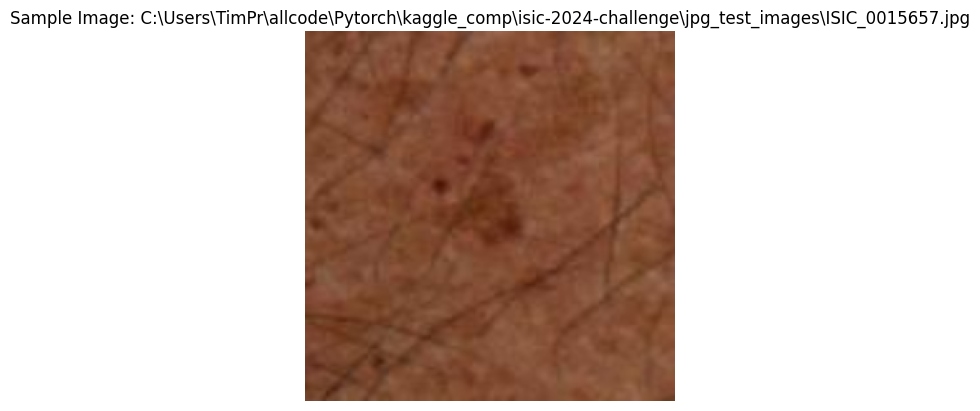

In [30]:
import matplotlib.pyplot as plt

# Define the test dataset
test_dataset = TestMoleDataset(image_dir=output_folder, transform=test_transform)

# Print dataset length
print(f"Total test images: {len(test_dataset)}")

# Load and display a sample image
sample_image, sample_path = test_dataset[0]
print(f"Sample image path: {sample_path}")
print(f"Image tensor shape: {sample_image.shape}")

# Convert tensor back to image for visualization
sample_image = sample_image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) -> (H, W, C)

# Undo normalization for display
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
sample_image = sample_image * std + mean  # Denormalize

# Show the image
plt.imshow(sample_image)
plt.axis("off")
plt.title(f"Sample Image: {sample_path}")
plt.show()


In [31]:
import torch
import pandas as pd

# Load trained model (adjust path if needed)
model.eval()  # Set to evaluation mode

# Ensure model runs on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Store results
results = []

# Disable gradients for inference
with torch.no_grad():
    for images, img_paths in test_loader:
        images = images.to(device)
        logits = model(images)  # Model outputs logits

        # Apply sigmoid to get the probability of class 1
        probabilities = torch.sigmoid(logits).squeeze(1)  # Squeeze to remove unnecessary dimensions

        # Store probabilities with image names (excluding the extension)
        for img_path, prob in zip(img_paths, probabilities.cpu().numpy()):
            # Extract the ISIC ID from the image path (e.g., ISIC_0015657.jpg -> ISIC_0015657)
            isic_id = os.path.splitext(os.path.basename(img_path))[0]
            results.append({"isic_id": isic_id, "target": prob})

# Convert results to DataFrame and save
df = pd.DataFrame(results)
df.to_csv("test_predictions.csv", index=False)

print("Predictions saved to test_predictions.csv")


Predictions saved to test_predictions.csv


In [26]:
# # Save the trained model
torch.save(mole_model.state_dict(), "mole_classifier_best_model.pt")

# print("Model saved as 'mole_classifier_best_model.pth'")


In [112]:
# %tensorboard --logdir "C:\Users\TimPr\allcode\Pytorch\kaggle_comp\lightning_logs\mole_classifier"